# Solution Report

This file aims to study each approach, detailing it's main strategy as well as weighting in on it's advantages and disadvantages

**Important Note:** If you want to run this report, be sure you are using a **Linux** distribution

### Index
 - Setting up the Environment
 - Brute-Force
 - Open-MP
 - MPI
 - Comparison

## Setting up the Environment

To generate the example graphs, as well as checking if the cliques we found are correct, the `networkx` library is used. Let's make sure that this library is installed

In [2]:
%pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Note that there aren't any graphs in the directory currently. Let's generate them using the `generate_graph.py` in the `scripts` folder. We will generate just one graph for now to be used as a test for the algorithms.

In [3]:
# generate_graph.py args: argv[1] = n_edges, argv[2] = probability of connection, argv[3] = filename
%run scripts/generate_graph.py 500 0.3 test_graph.txt

Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.


## Brute-Force

### Description
The brute force approach to finding the maximum clique in a graph is a method that systematically explores all possible combinations of vertices to identify the largest complete subgraph, known as a clique. It starts with an initial vertex and iteratively adds vertices to a candidate clique, checking if the addition maintains the clique property. This exhaustive approach guarantees the optimality of the solution, but its computational complexity grows exponentially with the number of vertices, making it impractical for large graphs.

### Running the Code

As we will evaluate the efficiency of the algorithim itself, we won't compile it with the optimization options of the compiler (-O flag). Also, we will use the -g to include debug symbols.


In [4]:
# Compiling
!g++ -Wall -O3 -g scripts/brute_force.cpp -o ./executables/brute_force

In [5]:
# Running
!./executables/brute_force graphs/test_graph.txt

Size of the maximum clique: 9
Maximum clique found:
[8, 14, 57, 127, 232, 288, 342, 468, 480]
Tempo de execução: 62 ms


Let's check the answer using the `check_answer.py` file

In [6]:
%run scripts/check_answer.py graphs/test_graph.txt

Size of the maximum clique:  9
Maximum cliques found:
[8, 14, 57, 127, 232, 288, 342, 468, 480]


The answer checks out! Now let's have a look at the performance of the code

In [7]:
!valgrind --tool=callgrind --callgrind-out-file=brute_force.out ./executables/brute_force graphs/test_graph.txt

==5771== Callgrind, a call-graph generating cache profiler
==5771== Copyright (C) 2002-2017, and GNU GPL'd, by Josef Weidendorfer et al.
==5771== Using Valgrind-3.18.1 and LibVEX; rerun with -h for copyright info
==5771== Command: ./executables/brute_force graphs/test_graph.txt
==5771== 
==5771== For interactive control, run 'callgrind_control -h'.
Size of the maximum clique: 9
Maximum clique found:
[8, 14, 57, 127, 232, 288, 342, 468, 480]
Tempo de execução: 2130 ms
==5771== 
==5771== Events    : Ir
==5771== Collected : 760396648
==5771== 
==5771== I   refs:      760,396,648


In [8]:
!callgrind_annotate brute_force.out scripts/brute_force.cpp --auto=no

--------------------------------------------------------------------------------
Profile data file 'brute_force.out' (creator: callgrind-3.18.1)
--------------------------------------------------------------------------------
I1 cache: 
D1 cache: 
LL cache: 
Timerange: Basic block 0 - 107882781
Trigger: Program termination
Profiled target:  ./executables/brute_force graphs/test_graph.txt (PID 5771, part 1)
Events recorded:  Ir
Events shown:     Ir
Event sort order: Ir
Thresholds:       99
Include dirs:     
User annotated:   scripts/brute_force.cpp
Auto-annotation:  off

--------------------------------------------------------------------------------
Ir                   
--------------------------------------------------------------------------------
760,396,648 (100.0%)  PROGRAM TOTALS

--------------------------------------------------------------------------------
Ir                    file:function
--------------------------------------------------------------------------------
58

Ao expandir a saída do `annotate`, é possível enxergar que as partes do código com maior proporção de execuções destinadas são:

Scripts e biblioteca
 - 76.21%: `brute_force.cpp` (o próprio código em c)
 - 12.04%: `stl_vector.h:main` (biblioteca vector)
 - 11.75%: outras bibliotecas

Não temos uma maneira de melhorar o código da biblioteca, então teremos que nos ater à mudança no nosso código.

Dentre as partes do programa, nota-se que: 
 - 4.83% das execuções são na função de ler o grafo `ReadGraph`
 - 75,83% das execuções ocorrem na seguinte parte:

```c++
( 0.03%)           for (int connection1 : connections)
                   {
                       vector<int> clique = {currentNode, connection1}; // Move initialization here
( 7.43%)               for (int connection2 : connections)
                       {
( 1.48%)                   bool inClique = true;
(24.16%)                   for (int member : clique)
                           {
(15.61%)                       if (graph[member][connection2] == 0)
(24.16%)                       inClique = false;
                           }
( 2.97%)                    if (inClique)
                                clique.push_back(connection2);
                        }
( 0.02%)                if (clique.size() > maximumClique.size())
                        maximumClique = clique;
                   }
               }
```

It seems that the issue is in the inner loops. Let's try to parallelize the code to make it faster.

## Open-MP

### Description

OpenMP stands for Open Multi-Processing. It's a widely used API (Application Programming Interface) for shared-memory multiprocessing programming in C, C++, and Fortran. It simplifies parallel programming by using compiler directives to enable parallelism in code.

By adding a simple directive before the outer-loop, we can divide the code into threads. However, we need to be careful as the comparison at the end of the algorithm creates a dependence between threads, needing the `critical` directive.

```cpp

    vector<int> maximumClique;

    #pragma omp parallel for
    for (int currentNode = 0; currentNode < numNodes; currentNode++)
    {
        // Pega todas as conexões
        vector<int> connections;
        for (int node = 0; node < numNodes; node++)
        {
            if (graph[currentNode][node] == 1)
                connections.push_back(node);
        }

        // Para cada conexão do nó atual...
        for (int connection1 : connections)
        {
            // rest of the code ...

        #pragma omp critical
            if (clique.size() > maximumClique.size())
                maximumClique = clique;
        }
    }
```

### Running the code

We need to run openMP files with the `-fopenmp` flag:

In [9]:
# Compiling
!g++ -Wall -O3 -fopenmp scripts/open_mp.cpp -o ./executables/open_mp

In [10]:
# Running
!./executables/open_mp graphs/test_graph.txt

Size of the maximum clique: 9
Maximum clique found:
[8, 14, 57, 127, 232, 288, 342, 468, 480]
Tempo de execução: 50 ms


## MPI

### Description
OpenMP parallelizes into cores inside one computer. The next step is parallelizing between different computers working in a network - in a cluster! To do so, we need to use MPI, which is a communication protocol allowing different nodes or processes across a networked cluster to exchange data and coordinate parallel computations efficiently.

### Running the Code

The most popular schedualer for running on clusters is Slurm. Slurm is an open-source job scheduler used in high-performance computing (HPC) environments. It manages and schedules the allocation of resources like processors and memory for running jobs on clusters or supercomputers.

Unfortunatly, MPI doesn't allow us to exchange 2D vectors between tasks. Therefore, we need to refactor the graph to a one-dimentional vector.

Besides creating a new script, available at `scripts/mpi_flatten`, it was necessary to create a `mpi_flatten.slurm` file. This file contains the instructions to run on the cluster.

## Comparison

Making graphs of different sizes

In [11]:
#Making graphs of sizes 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000
sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
graph_names = list()

for size in sizes:
    %run scripts/generate_graph.py {size} 0.5 graph_{size}
    graph_names.append(f"graph_{size}.txt")


Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/g

Fetching data from `brute_force.cpp` and `open_mp.cpp` files

In [12]:
# We can fetch the time data by splitting the program output
output = !./executables/brute_force graphs/graph_100.txt
print(output[-1].split(" "))
print(output[-1].split(" ")[-2])

['Tempo', 'de', 'execução:', '1', 'ms']
1


In [13]:
brute_force_times = list()
open_mp_times = list()

for graph in graph_names:
    output_brute_force = !./executables/brute_force graphs/{graph}
    brute_force_times.append(int(output_brute_force[-1].split(" ")[-2]))
    output_open_mp = !./executables/open_mp graphs/{graph}
    open_mp_times.append(int(output_open_mp[-1].split(" ")[-2]))

In [14]:
job_ids = [i for i in range(654, 664)]
MPI_times = list()

for job_id in job_ids:
    with open(f"slurm-out/slurm-{job_id}.out", "r") as f:
        MPI_times.append(int(f.read().split(" ")[-2]))


In [15]:
print(brute_force_times)
print(open_mp_times)
print(MPI_times)

[1, 11, 37, 75, 146, 254, 420, 647, 936, 1227]
[26, 19, 13, 30, 61, 110, 174, 262, 378, 520]
[279, 309, 292, 292, 385, 510, 864, 928, 1179, 1614]


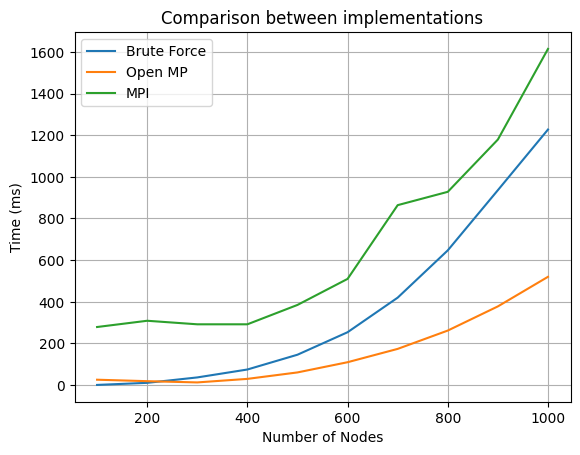

In [16]:
import matplotlib.pyplot as plt

# Plotting the graph
plt.plot(sizes, brute_force_times, label='Brute Force')
plt.plot(sizes, open_mp_times, label='Open MP')
plt.plot(sizes, MPI_times, label='MPI')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (ms)')
plt.title('Comparison between implementations')
plt.legend()
plt.grid()
plt.show()


# Performance Analysis

The time taken for exhaustive search also increases with graph size, as expected due to its inherent nature of exploring all possible combinations. However, it's consistently slower than OpenMP across all graph sizes, highlighting the efficiency gain achieved through parallelization.

Albeit, the execution times for MPI vary inconsistently with the graph size. Unlike OpenMP, the times don't consistently decrease or increase with graph size. This unexpected behavior might indicate issues with the MPI implementation or the way the algorithm scales in a distributed environment. But why was that?

Upon closer examination of the `.slurm` configuration file, it becomes evident that the job was configured to utilize only two nodes within the available cluster infrastructure. This restriction stemmed from the limited resources, restricting the computational capacity to these two nodes exclusively. Notably, the absence of further internal parallelization mechanisms, such as OpenMP, within each node resulted in a configuration where the nodes functioned akin to two individual threads. Due to the larger communication overhead between these nodes (in comparison to communication between cores in the same cpu), the overall efficiency was impacted.

Additionally, the work environment significantly differed across these implementations. While the OpenMP and brute force algorithms were executed on my personal machine, the MPI implementation ran on a simulated cluster environment utilizing one physical machine communicating across three virtual machines (VMs). This setup inherently introduced complexities related to virtualization, network latency, and the coordination of processes across multiple simulated nodes.

The disparity in execution environments could have notably influenced the MPI execution times, introducing overheads and bottlenecks associated with virtualized communication between nodes. These complexities, coupled with the constraints of simulating a cluster environment on a single machine, likely contributed to the inconsistent scaling observed in MPI execution times, deviating from the anticipated behavior.